# <center>UE 4.1 - Machine Learning </center>

UE 4.1 Machine Learning
Noms et prénoms : GETA Rayane, AZOU Raphael 


In [1]:
import numpy as np
import sklearn as sk
import os
import cv2
from matplotlib import pyplot as plt
import skimage
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import random


path = "./images_ISAR"

---

## Partie I - Analyse de données ISAR

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Généralités sur la base de données</h3>

#### Lecture du fichier
Premièrement, on load le fichier zip contenant les images.

810


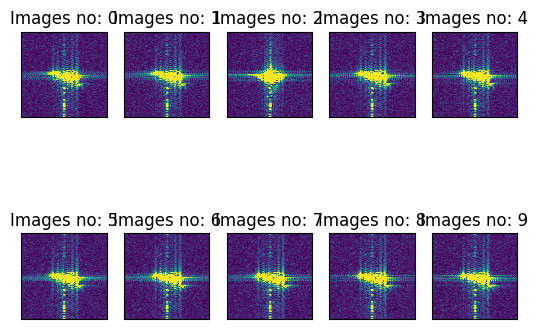

In [2]:
images = []
for image in os.listdir(path):
    img = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

print(len(images))

##Afficage de 10 d'entre elles
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[10+i],vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.title('Images no: %i' %i)


Il y a 810 images dans le dossier "images_ISAR".

#### Séparation des images par classes

In [3]:
# Store the image file names in a list as long as they are bmps
nom_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.bmp']
type_appareil=[]
for k in nom_images:
    type_appareil.append(k.split("_")[0])  #split the names before the _

#print(type_appareil)
values, counts = np.unique(type_appareil, return_counts=True)  #count the number of different elements in the list

print(values,counts)

['A10' 'F14' 'F15' 'F16' 'F4'] [162 162 162 162 162]


#### Histogramme

Number of samples 810
Number of class 5
Number of sample per class 162


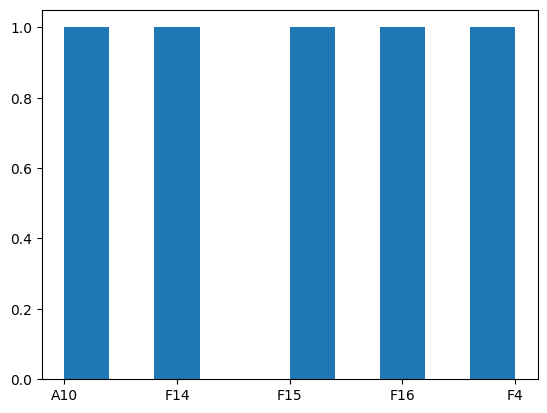

In [4]:
print("Number of samples", len(images))
print("Number of class", len(values))
hist_target = plt.hist(values, bins=10)
print("Number of sample per class", counts[0])




#### Dimension de l'espace de données

In [5]:
# a completer
dim = images[0].shape[0]*images[0].shape[1]
print(f"Dimension de l'image : {dim:d}")

Dimension de l'image : 65536


On constate que la dimension de l'espace de donnée est relativement élevée pour utiliser par exemple des classsifieurs K-NN
Il faut envisager une ou plusieurs techniques de réduction de l'espace de données.

#### Réduction de la dimension des données



##### Affichage des niveaux de gris d'une image aléatoire

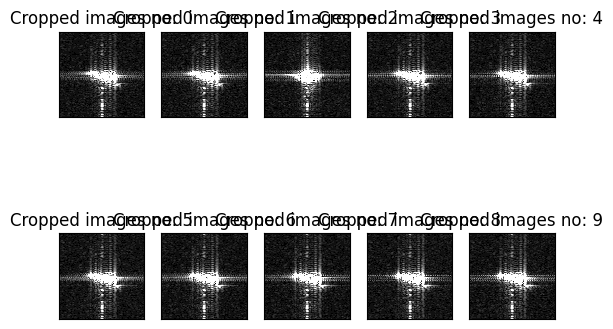

In [6]:
def crop(a):
    new=[]
    for i in range(len(a)):
        new.append(a[i][50:200,50:200])
    return new

cropped_images = crop(images)
##Affichage après découpage
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cropped_images[10+i],vmax=16, cmap = 'gray', interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.title('Cropped images no: %i' %i)

newDim = cropped_images[0].shape[0] * cropped_images[0].shape[1]
gain = abs((newDim - dim) / dim) * 100
print(f"Nouvelle dimension : {newDim:d}")
print(f"Gain de réduction : {gain:.2f} %")


Voici quelques images "croppées".

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Load BDD</h3>

Ici, on a une fonction qui à partir d'un dossier donné d'images (de format .bmp) renvoie la matrice des donneés et le vecteur des labels

In [7]:
def load_bdd(path):
    for image in os.listdir(path):
        img = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(crop(img))
        
    #On charge la matrice des données
    n_samples = len(images)
    dim = images[0].shape[0]*images[0].shape[1]
    X = images.reshape(n_samples, dim)
    
    
    # Labels
    # Store the image file names in a list as long as they are bmps
    nom_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.bmp']
    type_appareil=[]
    for k in nom_images:
        type_appareil.append(k.split("_")[0])  #split the names before the _

    #print(type_appareil)
    labels, counts = np.unique(type_appareil, return_counts=True)  #count the number of different elements in the list
    
    return X, labels

## Partie II - Extraction des caractéristiques discriminantes – Image polaire

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Fonction polaire()</h3>

Text(0.5, 1.0, 'Image polaire : 9')

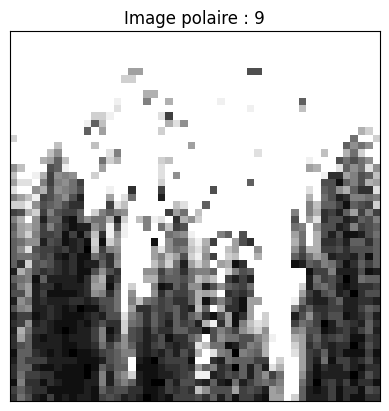

In [8]:
#Image aléatoire
rnd_index = random.randint(0, len(images) - 1)

# Sélection de l'image correspondant à l'indice aléatoire
image_aleatoire = images[rnd_index]

# exemple de la fonction polaire
def polaire(image, Nr=50, Mtheta=50, Rmax=50):
    M, N = image.shape
    center_x, center_y = N//2, M//2
    polar_image = np.zeros((Nr, Mtheta))
    dtheta = 2*np.pi/(Mtheta-1)
    dr = Rmax/(Nr-1)
    for m in range(Nr):
        for n in range(Mtheta):
            theta = -np.pi + (n-1)*dtheta
            r = (m-1)*dr
            x = center_x + r*np.cos(theta)
            y = center_y + r*np.sin(theta)
            x, y = int(x), int(y)
            if x >= N or y >= M:
                continue
            polar_image[m,n] = image[x, y]

    return polar_image

# A compléter
plt.imshow(polaire(image_aleatoire),vmax=16, cmap = 'gray', interpolation='nearest')
plt.xticks(())
plt.yticks(())
plt.title('Image polaire : %i' %i)

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Invariances des images polaires</h3>

### Invariance par rotation

In [9]:

# Charger l'image
image = Image.open("image.jpg")

# Rotation de l'image de 45 degrés dans le sens horaire
image_rotatee = image.rotate(45)

FileNotFoundError: [Errno 2] No such file or directory: 'image.jpg'

### Invariance par changement d'échelle

In [ ]:
#Changement d'échelle: scale = 3.5
image = Image.open("image.jpg")

# Calculer les nouvelles dimensions
largeur, hauteur = image.size
nouvelle_largeur = int(largeur * 3.5)
nouvelle_hauteur = int(hauteur * 3.5)

# Redimensionner l'image
image_redimensionnee = image.resize((nouvelle_largeur, nouvelle_hauteur))

### Invariance par changement d'échelle et rotation

In [ ]:
#Changement d'échelle: scale = 3.5


L'image obtenue est de taille (50x50).

<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Nouveau vecteurs caractéristiques: $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ </h3>

Commençons pas regarder le résultats des vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ sur un image aléatoire.

<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Invariances des vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$</h3>

### Invariance par rotation et changement d'échelle

In [ ]:
#Changement d'échelle: scale = 3.5


On observe que les vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ sont les mêmes après les transformation mais ils ont été translatés.
Evaluons maintenant les différences.


### Mesure de distances eucliennes

#### Cross-correlation pour la rotation

Pour une multitude d'angle, nous allons calculer le $\mathbf{I}_{\text{\theta}}$ et calculer la correlation. Ainsi, on pourra tracer la courbe de corrélation en fonction de ${\theta}$.


In [ ]:

    corr = np.corrcoef(Itheta, Itheta_rot)[0,1]
    corr = np.abs(corr)
    C.append(corr)

    # Trouver le shift correspondant à la meilleure correspondance
    shift = np.abs(np.argmin(Itheta)-np.argmin(Itheta_rot))
    S.append(shift)



---

## Partie III - Classification

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Descripteur</h3>

#### Matrice data




<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Classifieur C1</h3>

In [ ]:
def classifieurC1_Itheta(BA,BT,n_neigh):

    return




In [ ]:
def classifieurC1_II(BA,BT,n_neigh):


<div class="alert alert-info">
<h3 class="alert-heading"> Question 5 - Classifieur C2 </h3>

<div class="alert alert-info">
<h3 class="alert-heading"> Question 6 - Rotation et changement d'échelle </h3>